In [ ]:
%load_ext autoreload
%autoreload 2
from pyotf.otf import HanserPSF, apply_aberration, apply_named_aberration
import numpy as np
from data.visualise import scatter_3d, scatter_yz, show_psf_axial, plot_with_sphere, grid_psfs
import matplotlib.pyplot as plt
from tifffile import imread

In [ ]:
# 2D version
from scipy.optimize import minimize
from functools import partial
from scipy.optimize import least_squares
from scipy.stats import multivariate_normal as mvn, norm
from scipy.linalg import cholesky
plt.rcParams['figure.figsize'] = [5, 10]

psf = imread('/home/miguel/Projects/uni/phd/smlm_z/final_project/smlm_3d/tmp.tif').squeeze()[200]


def param_to_cholesky(sd_x, sd_y):
    cov = np.eye(len(psf.shape)) * [sd_x, sd_y]
    chol = cholesky(cov, lower=True)
    print(chol)
    assert np.array_equal(chol @ chol.T.conj(), cov)
    return chol[np.tril_indices(len(cov.shape))]

def remove_bg(img):
    img = img / img.max()
    bg_level = img.min()
    img = img - bg_level
    img[img<0] = 0
    img /= img.sum()
    return img

def render_psf(params, X, target_psf_shape):
    res = gauss_func(params, X)
    return res.reshape(*target_psf_shape)
    
def gauss_func(params, X):
    mu0, mu1, skew0, skew1, sd_x, sd_y, A = params
    mu = np.array([mu0, mu1])
    skew = np.array([skew0, skew1])
    cov = np.array([
        [sd_x,  0], 
        [0, sd_y], 
    ])
    
    cov = cov @ cov.T.conj()
    
    mod = MultiVariateSkewNorm(a=skew, mean=mu, cov=cov)
    res = mod.pdf(X)
#     res = multivariate_normal.pdf(X, mean=mu, cov=cov)
    res *= A
    return res

def plot_max(img):
    plt.rcParams['figure.figsize'] = [20, 10]
    max_z = img.max(axis=(1,2))
    plt.plot(max_z)
    
def fitGaussian(psf):
    def gaussian3DPDFFunc(params, X, Y):
        res = gauss_func(params, X)
        mse_val = (((Y-res)**2) * Y).mean()
        return mse_val
    psf = remove_bg(psf)
    
    
    # prepare the data for curvefit

    X = np.array([l for l in np.ndindex(*psf.shape)])
    Y = psf.ravel()


    X = np.array(X.astype(np.float32))
    Y = np.array(Y.astype(np.float32))
    
    sd_x = 4
    sd_y = 4
    chol_vals = param_to_cholesky(sd_x, sd_y)
    amp = 1.5
    mean_pos = np.array([np.argmax(np.mean(psf, axis=i)) for i in range(len(psf.shape))])
    print(mean_pos)
    p0 = np.concatenate((mean_pos, chol_vals, np.array([amp])))

    func = partial(gaussian3DPDFFunc, X=X, Y=Y)
    res = least_squares(func, x0=p0, verbose=1, ftol=1e-15, gtol=1e-40, xtol=1e-16, max_nfev=2000)
    print(res)
    
    print(p0)
    print(res.x)
#     params = np.array([16.0, 16.0, 5.0, 5.0, 1.0])
    pred_img = render_psf(res.x, X, psf.shape)
    
    initial = render_psf(p0, X, psf.shape)
    lst_imgs = [initial, psf, pred_img, pred_img-psf]
    imgs = np.concatenate(lst_imgs, axis=-1)
    print(imgs.shape)
    plt.imshow(imgs)
    plt.show()
#     plt.imshow(pred_img)
#     plt.show()
#     plt.imshow(psf)
#     plt.show()
#     plt.imshow(pred_img-psf)
#     plt.show()

X = np.array([l for l in np.ndindex(*psf.shape)])

X = np.array(X.astype(np.float32))

# [mean_x, mean_y, sd_x, skew, sd_y, amp]
# sd_x = 4
# sd_y = 4
# chol_vals = param_to_cholesky(sd_x, sd_y)
# amp = 1.5
# p0 = np.concatenate((np.array([16.0, 16.0]), chol_vals, np.array([amp])))
# print(p0)
# for i in np.arange(0, 1, 0.1):
#     p0[3] = i
#     pred_img = render_psf(p0, X, psf.shape)
#     plt.imshow(pred_img)
#     plt.show()
    
fitGaussian(psf)

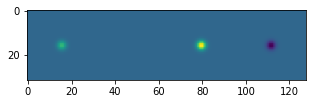

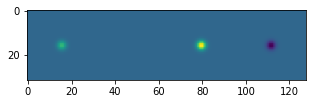

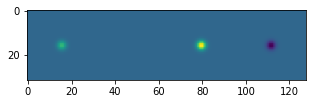

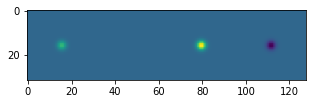

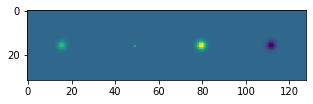

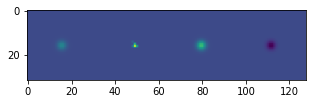

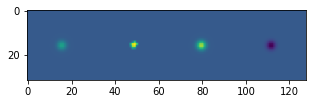

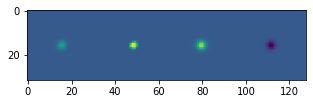

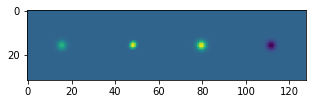

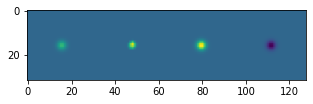

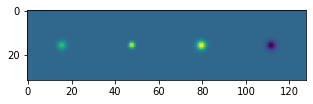

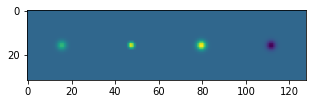

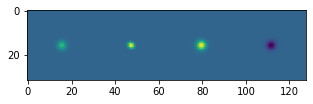

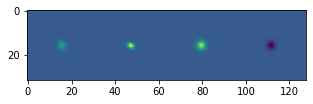

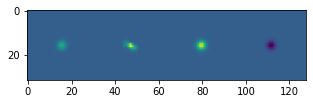

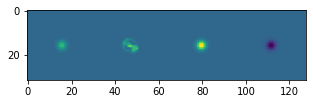

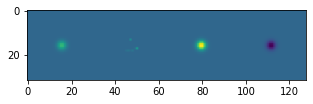

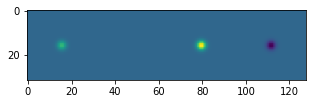

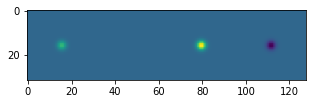

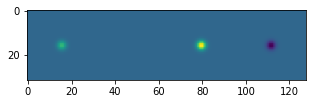

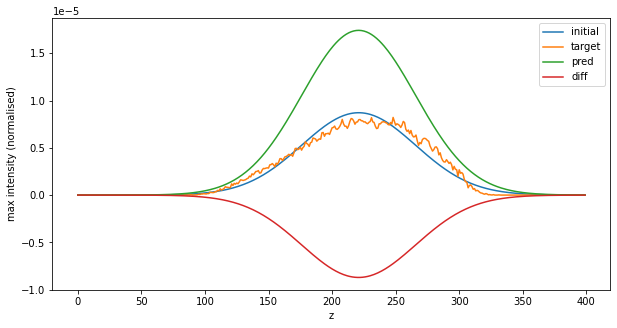

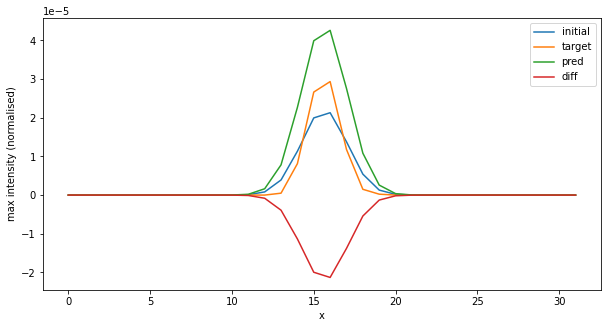

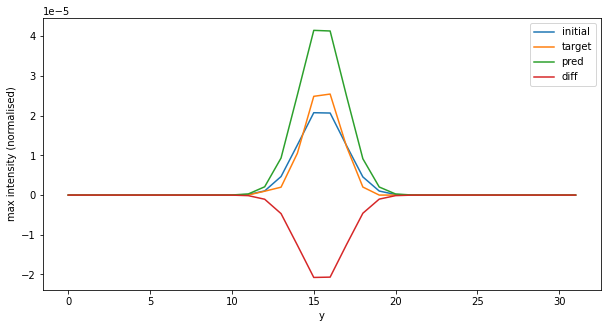

In [14]:
from scipy.optimize import minimize
from functools import partial
from scipy.optimize import least_squares
from scipy.stats import multivariate_normal as mvn, norm

from scipy.linalg import cholesky
import scipy.ndimage as ndi 

plt.rcParams['figure.figsize'] = [5, 10]

psf = imread('/home/miguel/Projects/uni/phd/smlm_z/final_project/smlm_3d/tmp.tif').squeeze()

def compare_images(initial, target, pred_img, diff):
    lst_imgs = [initial, psf, pred_img, diff]
    
    imgs = np.concatenate(lst_imgs, axis=-1)
    for i in range(0, target.shape[0], target.shape[0]//20):
        plt.imshow(imgs[i])
        plt.show()
    
    plt.rcParams['figure.figsize'] = [10, 5]
    for title, sum_axes in [('z', (1,2)), ('x', (0,2)), ('y', (0,1))]:
        plt.xlabel(title)
        plt.ylabel('max intensity (normalised)')
        for img, label in zip(lst_imgs, ['initial', 'target', 'pred', 'diff']):
            max_z = img.mean(axis=sum_axes)
            plt.plot(max_z, label=label)
        plt.legend()
        plt.show()

class MultiVariateSkewNorm:
    def __init__(self, a, mean, cov):
        self.dim  = len(a)
        self.a    = np.asarray(a)
        self.mean = mean
        self.cov  = cov

    def pdf(self, x):
        return np.exp(self.logpdf(x))
        
    def logpdf(self, x):
        x    = mvn._process_quantiles(x, self.dim)
        pdf  = mvn(self.mean, self.cov).logpdf(x)
        cdf  = norm(0, 1).logcdf(np.dot(x, self.a))
        return np.log(2) + pdf + cdf
    

def param_to_cholesky(sds):
    n_dim = len(psf.shape)
    cov = np.eye(n_dim) * sds
    chol = cholesky(cov, lower=True)
    assert np.allclose(chol @ chol.T.conj(), cov)
    return chol[np.tril_indices(n_dim)]

def remove_bg(img):
    img = img / img.max()
    bg_level = img.max(axis=(1,2)).min()
    img = img - (bg_level * 1.3)
    img[img<0] = 0
    img /= img.sum()
    return img

def render_psf(params, X, target_psf_shape):
    res = gauss_func(params, X)
    img = res.reshape(*target_psf_shape)
    return img
    
def gauss_func(params, X):
#     mu0, mu1, sd_x, shear, sd_y, A = params
    n_dim = X.shape[1]
    
    A = params[-1]
    mus = params[0:n_dim]
    skews = params[n_dim:2*n_dim]
    chol_vals = params[2*n_dim:-1]
    
    cov = np.zeros((n_dim, n_dim))
    cov[np.tril_indices(n_dim)] = chol_vals
    
    cov = cov @ cov.T.conj()
    
    cov += (1e-10) * np.eye(n_dim)
    
    model = MultiVariateSkewNorm(skews, mus, cov)
    res = model.pdf(X)
#     res = skewnorm.pdf(X, np.zeros(mus.shape), mus, cov)
    res *= A
    return res


def fitGaussian(psf):
    def gaussian3DPDFFunc(params, X, Y):
        res = gauss_func(params, X)
        mse_val = (((Y-res)**2)).mean()
        return mse_val
    
    
    # prepare the data for curvefit

    X = np.array([l for l in np.ndindex(*psf.shape)])
    Y = psf.ravel()


    X = np.array(X.astype(np.float32))
    Y = np.array(Y.astype(np.float32))
    
    
    sd_x = 4
    sd_y = 4
    sd_z = 2000
    sds = np.array([sd_z, sd_x, sd_y])
    chol_vals = param_to_cholesky(sds)
    mean_vals = ndi.center_of_mass(psf)

    skew = np.zeros(psf.ndim)
    amp = 1.5
    p0 = np.concatenate((mean_vals, skew, chol_vals, np.array([amp])))

    print('Starting values')
    print(p0)
    func = partial(gaussian3DPDFFunc, X=X, Y=Y)
    res = least_squares(func, x0=p0, verbose=2, ftol=1e-15, gtol=1e-26, xtol=1e-16, max_nfev=100)
    
    print('Final values')
    print(res.x)
    
    print('means', res.x[0:3])
    print('skews', res.x[3:6])
    print('chol_amp', res.x[6:])
    pred_img = render_psf(res.x, X, psf.shape)
    
    initial = render_psf(p0, X, psf.shape)
    plt.imshow(initial[200])
    plt.show()
    
    compare_images(initial, psf, pred_img, pred_img-psf)
    return res.x


psf = remove_bg(psf)

X = np.array([l for l in np.ndindex(*psf.shape)])

X = np.array(X.astype(np.float32))
# res = fitGaussian(psf)

sd_x = 2
sd_y = 2
sd_z = 2000
sds = np.array([sd_z, sd_x, sd_y])
chol_vals = param_to_cholesky(sds)
mean_vals = ndi.center_of_mass(psf)

skew = np.zeros(psf.ndim)
skew[1] = 0
amp = 1
p0 = np.concatenate((mean_vals, skew, chol_vals, np.array([amp])))
pred_img_0 = render_psf(p0, X, psf.shape)


skew[1] = 100000
amp = 1
p0 = np.concatenate((mean_vals, skew, chol_vals, np.array([amp])))
pred_img_1 = render_psf(p0, X, psf.shape)

compare_images(pred_img_0, pred_img_1, pred_img_1, pred_img_0-pred_img_1)


    


In [ ]:
from scipy.stats import skewnorm
import numpy as np
import math
from scipy.special import erf
from   scipy.stats import (multivariate_normal as mvn,
                           norm)
from   scipy.stats._multivariate import _squeeze_output

def skew_func(x, a):
    norm_pdf = (1/np.sqrt(2*np.pi)) * np.exp(-np.power(x, 2)/2)
    cdf = (1/2) * (1+erf((a*x)/np.sqrt(2)))
    return 2 * norm_pdf * cdf

mean = np.array([4])
cov = np.array([1])
x = np.arange(-10, 10, 0.1)
for i in np.linspace(5, 5, 10):
    y = skew_func(x, i)
    plt.plot(x, y / y.max(), label=str(round(i, 3)))
plt.legend()
plt.show()



In [ ]:
# [mean_x, mean_y, sd_x, skew, sd_y, amp]
plt.rcParams['figure.figsize'] = [15, 5]

psf = imread('/home/miguel/Projects/uni/phd/smlm_z/final_project/smlm_3d/tmp.tif').squeeze()


psf = remove_bg(psf)
sd_x = 1
sd_y = 1
sd_z = 2000
sds = np.array([sd_z, sd_x, sd_y])
chol_vals = param_to_cholesky(sds)
amp = 1

chol_vals[1] = 2
# chol_vals[3] = 1
# chol_vals[4] = 1

mean_vals = ndi.center_of_mass(psf)
p0 = np.concatenate((mean_vals, chol_vals, np.array([amp])))
print(p0)

pred_img = render_psf(p0, X, psf.shape)

lst_imgs = [psf, pred_img]

print(chol_vals)
show_psf_axial(pred_img[75:-50])
plt.imshow(pred_img[:, 16, :].T)
plt.show()
plt.imshow(pred_img[:, :, 16].T)
plt.show()
for title, sum_axes in [('z', (1,2)), ('x', (0,2)), ('y', (0,1))]:
    plt.title(title)
    for img, label in zip(lst_imgs, ['target', 'pred']):
        max_z = img.max(axis=sum_axes)
        plt.plot(max_z, label=label)
    plt.legend()
    plt.show()

In [ ]:
import numpy as np
from   scipy.stats import (multivariate_normal as mvn,
                           norm)
from   scipy.stats._multivariate import _squeeze_output

class MultivariateSkewNorm:
    def pdf(self, x, skews, means, cov):
        return np.exp(self.logpdf(x, skews, means, cov))
        
    def logpdf(self, x, skews, means, cov):

def _mvn_skew(X, skews, means, cov):
    norm_dist = mvn(means, cov)
    pdf  = norm_dist.logpdf(X)
    cdf  = norm_dist.logcdf(np.multiply(skews[np.newaxis, :], X))
    pdf = np.exp(_squeeze_output(np.log(2) + pdf + cdf))
    return pdf
    
def mvn_skew(params, X):
    n_dim = X.shape[1]
    
    A = params[-1]
    mus = params[0:n_dim]
    skews = params[n_dim:2*n_dim]
    chol_vals = params[2*n_dim:-1]
    
    cov = np.zeros((n_dim, n_dim))
    cov[np.tril_indices(n_dim)] = chol_vals
    
    cov = cov @ cov.T.conj()
    
    cov += (1e-10) * np.eye(n_dim)
    
    pdf = _mvn_skew(X, skews, mus, cov)
    
    pdf *= A
    
    return pdf

def mvn_skew_loss(params, X, Y):
    res = mvn_skew(params, X)
    loss = ((Y-res)**2).mean()
    return loss


    
    
psf = np.zeros((32,32))

X = np.array([l for l in np.ndindex(*psf.shape)])

X -= psf.shape[0]//2
X = X / 10.0

cov = np.array([
    [1, 0],
    [0, 1]
])

means = np.array([0, 0])

skews = np.array([5, 0])

mvsn = MultivariateSkewNorm()
pred = mvsn.pdf(X, skews, means, cov).reshape(*psf.shape)
plt.imshow(pred.T)
plt.show()

# mvsn2 = MultivariateSkewNorm([0, 10000], means, cov)
# pred2 = mvsn2.pdf(X).reshape(*psf.shape)
# plt.imshow(pred2)
# plt.show()
# print(pred.sum(), pred2.sum())

In [40]:
from scipy.optimize import minimize
from functools import partial
from scipy.optimize import least_squares
from scipy.stats import multivariate_normal as mvn, norm
from tifffile import imread
from scipy.linalg import cholesky
import scipy.ndimage as ndi 
import matplotlib.pyplot as plt
import numpy as np
from   scipy.stats._multivariate import _squeeze_output
from data.visualise import scatter_3d, scatter_yz, show_psf_axial, plot_with_sphere, grid_psfs


Starting values
[7.00000000e+00 4.00000000e+00 4.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.23606798e+00 0.00000000e+00
 1.73205081e+00 0.00000000e+00 0.00000000e+00 1.73205081e+00
 1.00000000e+13]


/home/miguel/Projects/uni/venv/lib/python3.8/site-packages/scipy/optimize/_lsq/least_squares.py:110: UserWarning: Setting `xtol` below the machine epsilon (2.22e-16) effectively disables the corresponding termination condition.
  warn("Setting `{}` below the machine epsilon ({:.2e}) effectively "


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.1204e+02                                    1.10e+03    


/home/miguel/Projects/uni/venv/lib/python3.8/site-packages/scipy/stats/_multivariate.py:747: RuntimeWarning: divide by zero encountered in log
  return np.log(self.cdf(x))


       1             24         6.1226e+01      2.51e+02       5.68e-01       8.15e+04    
       2             26         1.2094e+01      4.91e+01       2.84e-01       7.19e+05    
       3             27         3.2320e+00      8.86e+00       7.11e-02       3.34e+05    
       4             32         3.2320e+00      2.21e-05       6.94e-05       2.26e+05    
       5             33         3.2314e+00      5.45e-04       1.73e-05       1.62e+05    
       6             34         3.2313e+00      9.74e-05       4.34e-06       1.40e+05    
       7             35         3.2311e+00      2.05e-04       1.08e-06       2.52e+05    
       8             39         3.2305e+00      5.65e-04       4.24e-09       1.92e+05    
       9             43         3.2297e+00      8.46e-04       6.62e-11       2.72e+05    
      10             48         3.2288e+00      9.33e-04       5.17e-13       2.84e+05    
      11             78         3.2286e+00      1.84e-04       3.59e-30       4.02e+05    

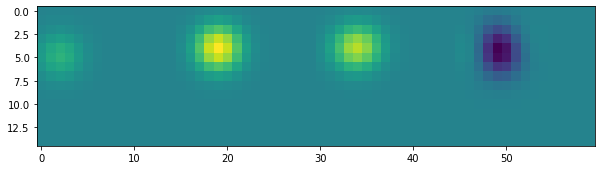

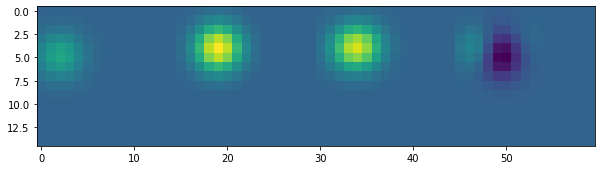

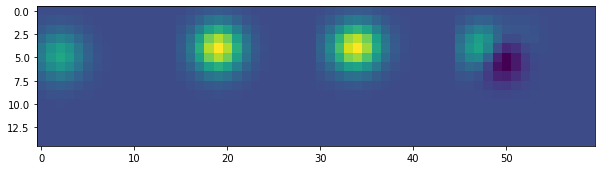

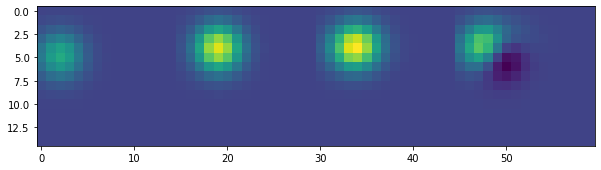

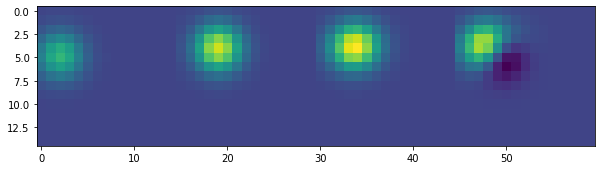

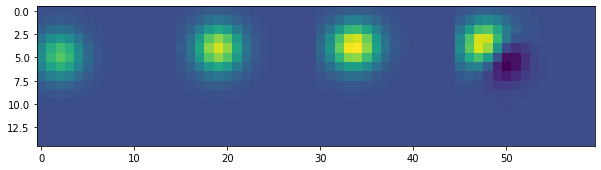

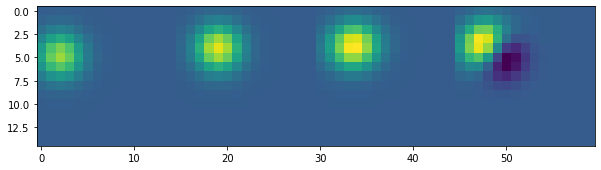

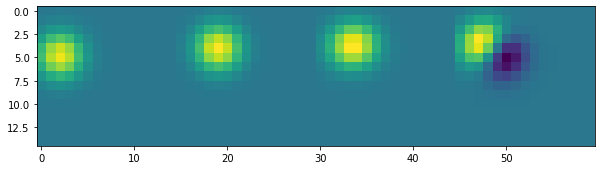

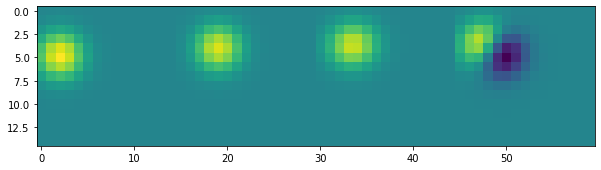

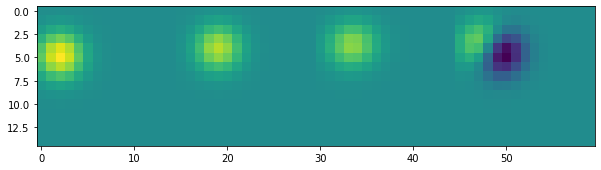

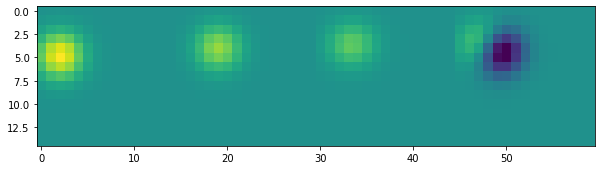

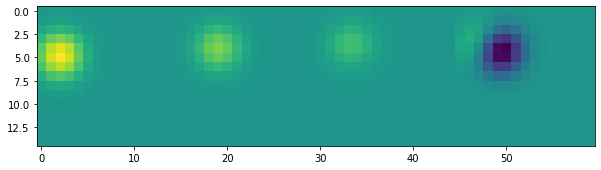

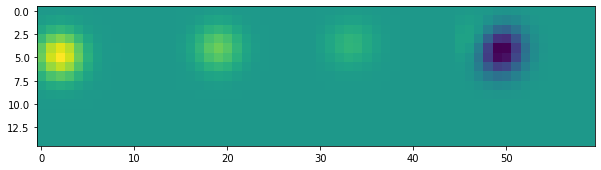

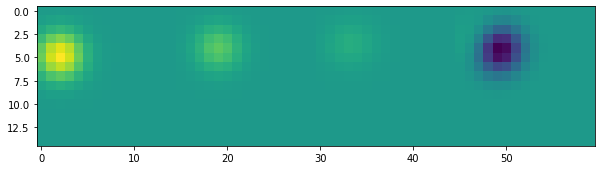

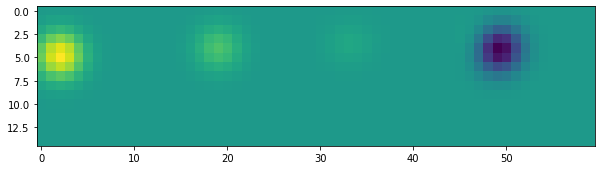

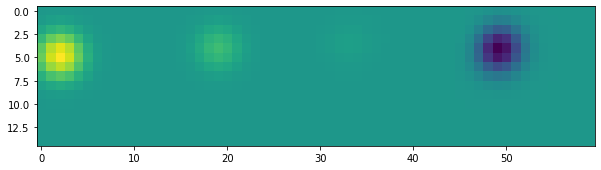

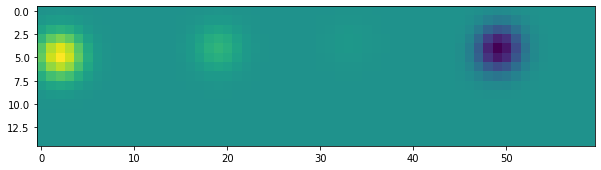

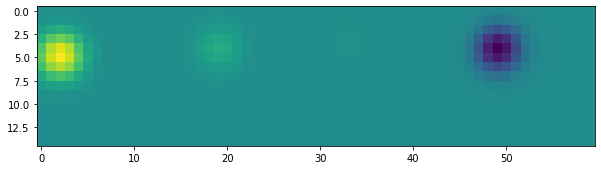

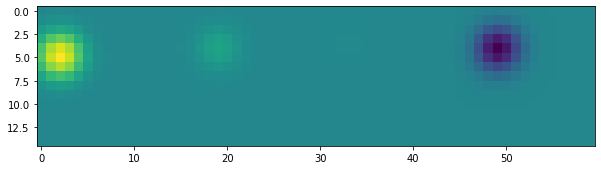

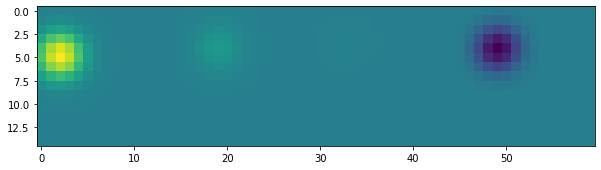

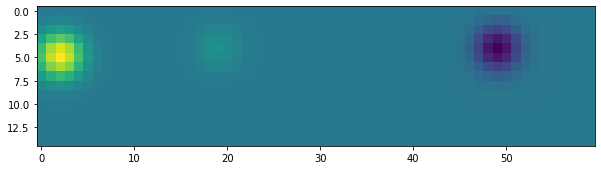

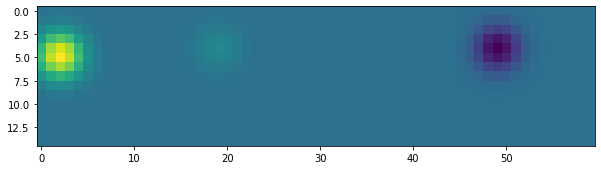

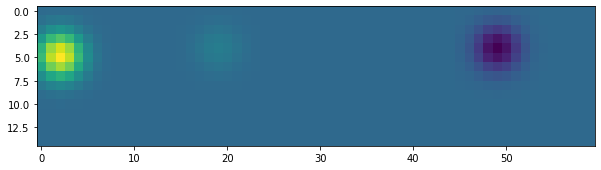

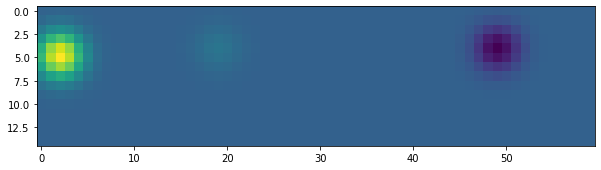

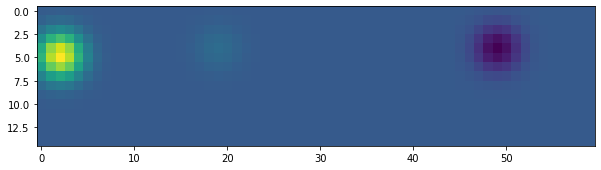

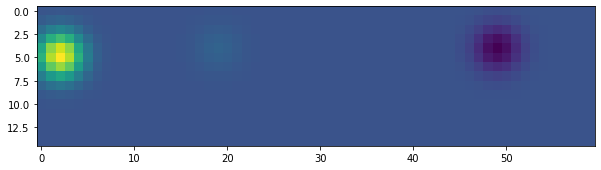

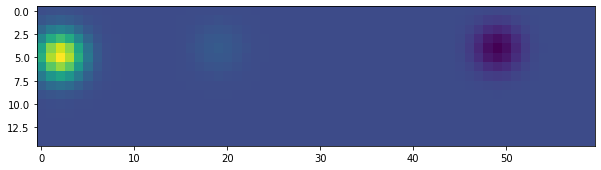

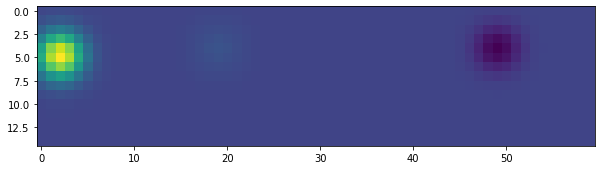

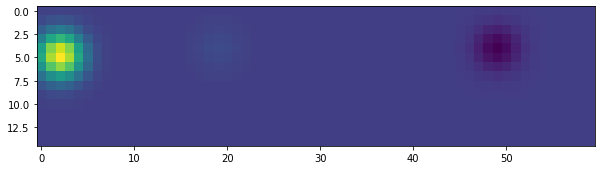

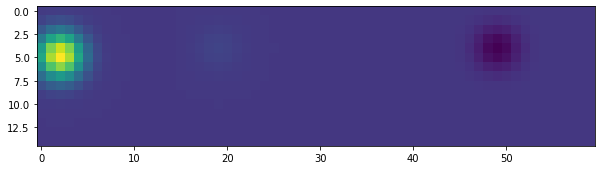

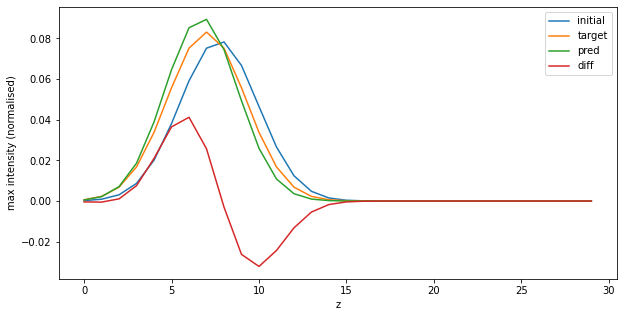

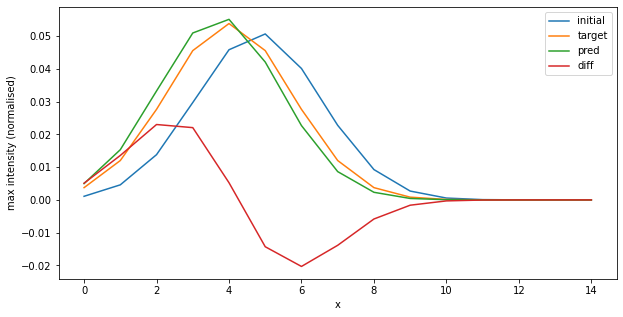

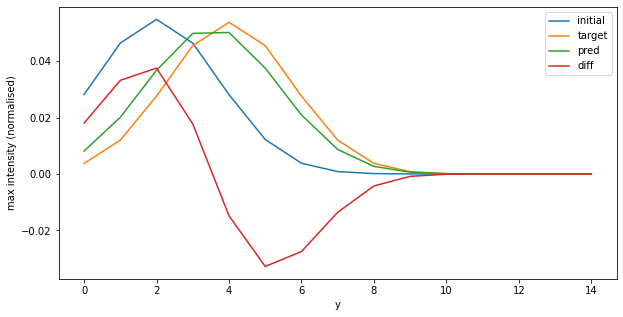

In [91]:
from scipy.optimize import minimize
from functools import partial
from scipy.optimize import least_squares
from scipy.stats import multivariate_normal as mvn, norm
from tifffile import imread
from scipy.linalg import cholesky
import scipy.ndimage as ndi 
import matplotlib.pyplot as plt
import numpy as np
from   scipy.stats._multivariate import _squeeze_output
from data.visualise import scatter_3d, scatter_yz, show_psf_axial, plot_with_sphere, grid_psfs
from jax import jit

plt.rcParams['figure.figsize'] = [10, 30]

psf = imread('/home/miguel/Projects/uni/phd/smlm_z/final_project/smlm_3d/tmp.tif').squeeze()

def compare_images(initial, target, pred_img, diff):
    lst_imgs = [initial, target, pred_img, diff]
    lst_imgs = [l / l.max() for l in lst_imgs]
    imgs = np.concatenate(lst_imgs, axis=-1)
    for i in range(target.shape[0]):
        plt.imshow(imgs[i])
        plt.show()
    
    plt.rcParams['figure.figsize'] = [10, 5]
    for title, sum_axes in [('z', (1,2)), ('x', (0,2)), ('y', (0,1))]:
        plt.xlabel(title)
        plt.ylabel('max intensity (normalised)')
        for img, label in zip(lst_imgs, ['initial', 'target', 'pred', 'diff']):
            max_z = img.mean(axis=sum_axes)
            plt.plot(max_z, label=label)
        plt.legend()
        plt.show()
    
def param_to_cholesky(sds):
    n_dim = len(psf.shape)
    cov = np.eye(n_dim) * sds
    chol = cholesky(cov, lower=True)
    assert np.allclose(chol @ chol.T.conj(), cov)
    return chol[np.tril_indices(n_dim)]

def remove_bg(img):
    img = img / img.max()
    bg_level = img.max(axis=(1,2)).min()
    img = img - (bg_level * 1.3)
    img[img<0] = 0
    img /= img.sum()
    return img

def render_psf(params, X, target_psf_shape):
    res = mvn_skew(params, X)
    img = res.reshape(*target_psf_shape)
    img = img / img.max()
    return img


def _mvn_skew(X, skews, means, cov):
    norm_dist = mvn(means, cov)
    pdf  = norm_dist.logpdf(X)
    cdf  = norm_dist.logcdf(np.multiply(skews, X))
    pdf = np.exp(_squeeze_output(np.log(2) + pdf + cdf))
    return pdf

def mvn_skew(params, X):
    n_dim = X.shape[1]
    
    A = params[-1]
    mus = params[0:n_dim]
    skews = params[n_dim:2*n_dim][np.newaxis, :]
    chol_vals = params[2*n_dim:-1]
    
    cov = np.zeros((n_dim, n_dim))
    cov[np.tril_indices(n_dim)] = chol_vals
    
    cov = cov @ cov.T.conj()
    
    cov += (1e-10) * np.eye(n_dim)
    
    pdf = _mvn_skew(X, skews, mus, cov)
    
    pdf *= A
    
    return pdf

def mvn_skew_loss(params, X, Y):
    res = mvn_skew(params, X)
    res /= res.max()
    loss = (abs(Y-res)**2)
    return loss.sum()



def fitGaussian(psf):    
    # prepare the data for curvefit

    X = np.array([l for l in np.ndindex(*psf.shape)])
    Y = psf.ravel()

    X = np.array(X.astype(np.float32))
    Y = np.array(Y.astype(np.float32))
    
    sd_x = 5
    sd_y = 5
    sd_z = 50
    sds = np.array([sd_z, sd_x, sd_y])
    chol_vals = param_to_cholesky(sds)
    mean_vals = ndi.center_of_mass(psf)

    skew = np.zeros(psf.ndim)
    amp = 1e13
#     p0 = np.concatenate((mean_vals, skew, chol_vals, np.array([amp])))

    print('Starting values')
    print(p0)
    p0[0] *= 1.1
    p0[1] *= 1.2
    p0[2] *= 0.5
    func = partial(mvn_skew_loss, X=X, Y=Y)
#     res = minimize(func, x0=p0, method='l-bfgs-b', tol=1e-16, options={'maxiter': 100})
    res = least_squares(func, x0=p0, verbose=2, ftol=2.3e-16, gtol=1e-15, xtol=2.3e-50, max_nfev=200)
    
    print('Final values')
    print(res.x)
    
    print('means', res.x[0:3])
    print('skews', res.x[3:6])
    print('chol_amp', res.x[6:])
    pred_img = render_psf(res.x, X, psf.shape)
    
    initial = render_psf(p0, X, psf.shape)
    
    compare_images(initial, psf, pred_img, pred_img-psf)
    return res.x


sd_x = 3
sd_y = 3
sd_z = 5
sds = np.array([sd_z, sd_x, sd_y])
chol_vals = list(param_to_cholesky(sds))
# means, skews, chol, amp
p0 = np.array([7, 4, 4, 0, 0, 0, *chol_vals, 1e13])

fake_psf = np.zeros((30, 15, 15))
X = np.array([l for l in np.ndindex(*fake_psf.shape)])
fake_psf = render_psf(p0, X, fake_psf.shape)

# fake_psf /= fake_psf.max()

# psf = psf / psf.max()
# psf = psf[slice(0, int(psf.shape[0]), 10)]
# fake_psf = psf
# show_psf_axial(fake_psf, '', 1)


# psf = remove_bg(psf)

# X = np.array([l for l in np.ndindex(*psf.shape)])

# X = np.array(X.astype(np.float32))

# fake_psf = remove_bg(fake_psf)
res = fitGaussian(fake_psf)

final_pred = render_psf(res, X, fake_psf.shape)


In [38]:
from jax.scipy.optimize import minimize
from jax import jit
from functools import partial
from scipy.optimize import least_squares
from jax.scipy.stats import multivariate_normal as mvn, norm
from tifffile import imread
from jax.scipy.linalg import cholesky
import scipy.ndimage as ndi 
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
from scipy.stats._multivariate import _squeeze_output
from data.visualise import scatter_3d, scatter_yz, show_psf_axial, plot_with_sphere, grid_psfs


plt.rcParams['figure.figsize'] = [10, 30]

psf = imread('/home/miguel/Projects/uni/phd/smlm_z/final_project/smlm_3d/tmp.tif').squeeze()

def compare_images(initial, target, pred_img, diff):
    lst_imgs = [initial, target, pred_img, diff]
    
    imgs = np.concatenate(lst_imgs, axis=-1)
    for i in range(0, target.shape[0], int(target.shape[0]%20)):
        plt.imshow(imgs[i])
        plt.show()
    
    plt.rcParams['figure.figsize'] = [10, 5]
    for title, sum_axes in [('z', (1,2)), ('x', (0,2)), ('y', (0,1))]:
        plt.xlabel(title)
        plt.ylabel('max intensity (normalised)')
        for img, label in zip(lst_imgs, ['initial', 'target', 'pred', 'diff']):
            max_z = img.mean(axis=sum_axes)
            plt.plot(max_z, label=label)
        plt.legend()
        plt.show()
    
def param_to_cholesky(sds):
    n_dim = len(psf.shape)
    cov = jnp.eye(n_dim) * sds
    chol = cholesky(cov, lower=True)
#     assert np.allclose(chol @ chol.T.conj(), cov)
    return chol[jnp.tril_indices(n_dim)]

def remove_bg(img):
    img = img / img.max()
    bg_level = img.max(axis=(1,2)).min()
    img = img - (bg_level * 1.3)
    img[img<0] = 0
    img /= img.sum()
    return img

def render_psf(params, X, target_psf_shape):
    res = mvn_skew(params, X)
    img = res.reshape(*target_psf_shape)
    return img

def _mvn_skew(X, skews, means, cov):
    pdf  = mvn.logpdf(X, means, cov)
    cdf  = mvn.logcdf(jnp.multiply(skews, X))
    pdf = jnp.exp(_squeeze_output(jnp.log(2) + pdf + cdf))
    return pdf
    
@jit
def mvn_skew(params, X):
    n_dim = X.shape[1]
    
    A = params[-1]
    mus = params[0:n_dim]
    skews = params[n_dim:2*n_dim][jnp.newaxis, :]
    chol_vals = params[2*n_dim:-1]
    
    cov = jnp.zeros((n_dim, n_dim))
    cov.at[jnp.tril_indices(n_dim)].set(chol_vals)
#     cov[jnp.tril_indices(n_dim)] = chol_vals
    
    cov = cov @ cov.T.conj()
    
    cov += (1e-10) * jnp.eye(n_dim)
    
    pdf = _mvn_skew(X, skews, mus, cov)
    
    pdf *= A
    
    return pdf

@jit
def mvn_skew_loss(params, X, Y):
    res = mvn_skew(params, X)
    loss = ((Y-res)**2).sum()
    return loss



def fitGaussian(psf):    
    # prepare the data for curvefit

    X = jnp.array([l for l in np.ndindex(*psf.shape)])
    Y = psf.ravel()


    X = jnp.array(X.astype(jnp.float32))
    Y = jnp.array(Y.astype(jnp.float32))
    
    
    sd_x = 4
    sd_y = 4
    sd_z = 2000
    sds = jnp.array([sd_z, sd_x, sd_y])
    chol_vals = param_to_cholesky(sds)
    mean_vals = ndi.center_of_mass(psf)

    skew = jnp.zeros(psf.ndim)
    amp = 1.5
    p0 = jnp.concatenate((mean_vals, skew, chol_vals, np.array([amp])))

    print('Starting values')
    print(p0)
    func = partial(mvn_skew_loss, X=X, Y=Y)
    res = least_squares(func, x0=p0, verbose=2, ftol=2.3e-16, gtol=1e-50, xtol=2.3e-16, max_nfev=100)
    
    print('Final values')
    print(res.x)
    
    print('means', res.x[0:3])
    print('skews', res.x[3:6])
    print('chol_amp', res.x[6:])
    pred_img = render_psf(res.x, X, psf.shape)
    
    initial = render_psf(p0, X, psf.shape)
    
    compare_images(initial, psf, pred_img, pred_img-psf)
    return res.x


sd_x = 4
sd_y = 8
sd_z = 4
sds = np.array([sd_z, sd_x, sd_y])
chol_vals = param_to_cholesky(sds)
# means, skews, chol, amp
p0 = np.concatenate((np.array([4, 8, 4, 0, 0, 0]).T, chol_vals.T, np.array([1]).T)).T
print(p0.shape)

fake_psf = np.zeros((15, 15, 15))
X = np.array([l for l in np.ndindex(*fake_psf.shape)])
fake_psf = render_psf(p0, X, fake_psf.shape)

fake_psf /= fake_psf.max()
# show_psf_axial(fake_psf, '', 1)


# psf = remove_bg(psf)

# X = np.array([l for l in np.ndindex(*psf.shape)])

# X = np.array(X.astype(np.float32))

# fake_psf = remove_bg(fake_psf)
show_psf_axial(fake_psf, '', 1)
res = fitGaussian(fake_psf)

final_pred = render_psf(res, X, fake_psf.shape)


(13,)


AttributeError: module 'jax.scipy.stats.multivariate_normal' has no attribute 'logcdf'

In [ ]:


dataset = 'openframe'
